Cleaning the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

# Load the CSV file
file_path = "2017_2025_combined.csv"  # your file path
df = pd.read_csv(file_path)

# Remove non data rows
# Some rows like "Arrestee Age" are headers repeated in the dataset.
df_cleaned = df[df['Arrest Offense'].str.contains("Arrestee", case=False, na=False) == False]

# Convert numeric columns
# Remove commas and convert them to floats.
numeric_columns = [
    'Murder and Nonnegligent Manslaughter',
    'Rape Total',
    'Robbery Total',
    'Aggravated Assault Total',
    'Violent Crime'
]

for col in numeric_columns:
    df_cleaned[col] = (
        df_cleaned[col]
        .astype(str)
        .str.replace(',', '', regex=False)
        .astype(float)
    )

# Drop invalid or empty rows
df_cleaned = df_cleaned.dropna(subset=['Year', 'Arrest Offense']).reset_index(drop=True)

# Print and Confirm results
print("Cleaned Data Summary:")
print(df_cleaned.info())
print("\nSample of Cleaned Data:")
print(df_cleaned.head())


Cleaned Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Year                                  135 non-null    int64  
 1   Demographic_Type                      135 non-null    object 
 2   Arrest Offense                        135 non-null    object 
 3   Murder and Nonnegligent Manslaughter  135 non-null    float64
 4   Rape Total                            135 non-null    float64
 5   Robbery Total                         135 non-null    float64
 6   Aggravated Assault Total              135 non-null    float64
 7   Violent Crime                         135 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 8.6+ KB
None

Sample of Cleaned Data:
   Year Demographic_Type Arrest Offense  Murder and Nonnegligent Manslaughter  \
0  2017              Age       

/tmp/ipython-input-4144103840.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = (
/tmp/ipython-input-4144103840.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = (
/tmp/ipython-input-4144103840.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

Research Question 1: Are certain ethnic groups of people more likely to commit crime?

In [ ]:
# Filter data for demographic type 'Race'
df_race = df_cleaned[df_cleaned['Demographic_Type'] == 'Race']

# Quick check
print(df_race.head())

    Year Demographic_Type                             Arrest Offense  \
8   2017             Race                                      White   
9   2017             Race                  Black or African American   
10  2017             Race           American Indian or Alaska Native   
11  2017             Race                                      Asian   
12  2017             Race  Native Hawaiian or Other Pacific Islander   

    Murder and Nonnegligent Manslaughter  Rape Total  Robbery Total  \
8                                   72.0        56.0          549.0   
9                                   51.0        26.0          350.0   
10                                   5.0         6.0           18.0   
11                                   1.0         0.0            1.0   
12                                   0.0         0.0            0.0   

    Aggravated Assault Total  Violent Crime  
8                     2166.0         2843.0  
9                      877.0         1304.0  
10

In [ ]:
# Group by Year and Race
race_crime_summary = (
    df_race.groupby(['Year', 'Arrest Offense'])
    ['Violent Crime']
    .sum()
    .reset_index()
)


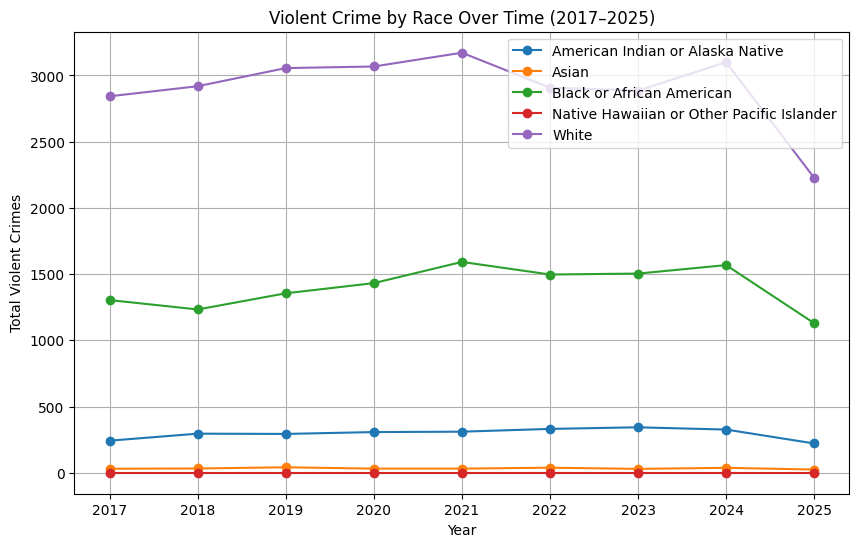

In [ ]:
# Plotting violent crime by race over time
plt.figure(figsize=(10,6))
for race in race_crime_summary['Arrest Offense'].unique():
    subset = race_crime_summary[race_crime_summary['Arrest Offense'] == race]
    plt.plot(subset['Year'], subset['Violent Crime'], marker='o', label=race)

plt.title("Violent Crime by Race Over Time (2017–2025)")
plt.xlabel("Year")
plt.ylabel("Total Violent Crimes")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Regression: Violent Crime ~ Race (categorical)
sm_model = smf.ols('Q("Violent Crime") ~ C(Q("Arrest Offense"))', data=df_race).fit()

print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:     Q("Violent Crime")   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     669.3
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           4.73e-36
Time:                        04:59:35   Log-Likelihood:                -284.99
No. Observations:                  45   AIC:                             580.0
Df Residuals:                      40   BIC:                             589.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [ ]:
# Extract regression results into a DataFrame
coef_df = sm_model.params.reset_index()
coef_df.columns = ['Race', 'Coefficient']

# Add p-values and confidence intervals
coef_df['p_value'] = sm_model.pvalues.values
coef_df['CI_lower'] = sm_model.conf_int()[0].values
coef_df['CI_upper'] = sm_model.conf_int()[1].values

# Remove the Intercept row (not a race category)
coef_df = coef_df[coef_df['Race'] != 'Intercept']

print(coef_df)

                                                Race  Coefficient  \
1                    C(Q("Arrest Offense"))[T.Asian]  -263.888889   
2  C(Q("Arrest Offense"))[T.Black or African Amer...  1105.111111   
3  C(Q("Arrest Offense"))[T.Native Hawaiian or Ot...  -296.444444   
4                    C(Q("Arrest Offense"))[T.White]  2612.333333   

        p_value     CI_lower     CI_upper  
1  3.871719e-04  -401.539326  -126.238452  
2  3.401013e-19   967.460674  1242.761548  
3  9.062182e-05  -434.094881  -158.794008  
4  3.619035e-33  2474.682897  2749.983770  


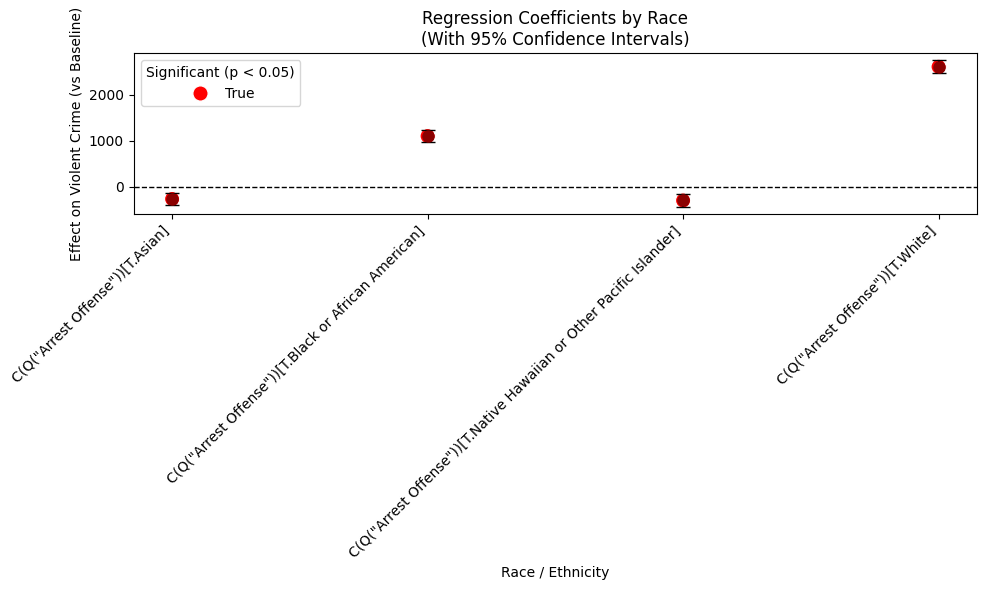

In [ ]:
plt.figure(figsize=(10,6))

# Color by significance (p < 0.05)
coef_df['Significant'] = coef_df['p_value'] < 0.05
palette = coef_df['Significant'].map({True: 'darkred', False: 'gray'})

# Plot coefficients with error bars
plt.errorbar(
    coef_df['Race'],
    coef_df['Coefficient'],
    yerr=[coef_df['Coefficient'] - coef_df['CI_lower'], coef_df['CI_upper'] - coef_df['Coefficient']],
    fmt='o',
    ecolor='black',
    capsize=5,
    markersize=8,
    color='darkred'
)

# Highlight significant coefficients
sns.scatterplot(
    data=coef_df,
    x='Race',
    y='Coefficient',
    hue='Significant',
    palette={True:'red', False:'gray'},
    s=120
)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Regression Coefficients by Race\n(With 95% Confidence Intervals)")
plt.xlabel("Race / Ethnicity")
plt.ylabel("Effect on Violent Crime (vs Baseline)")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Significant (p < 0.05)")
plt.tight_layout()
plt.show()

In [ ]:
# Filter the dataset for Race data
df_race = df_cleaned[df_cleaned['Demographic_Type'] == 'Race']

# Group by Year and Race, summing violent crimes
race_crime_summary = (
    df_race.groupby(['Year', 'Arrest Offense'])['Violent Crime']
    .sum()
    .reset_index()
)

In [ ]:
# One-hot encode 'Arrest Offense' (race)
encoder = OneHotEncoder(drop='first', sparse_output=False)
race_encoded = encoder.fit_transform(race_crime_summary[['Arrest Offense']])

# Combine encoded race data with the 'Year' column
X = np.concatenate([race_crime_summary[['Year']], race_encoded], axis=1)
y = race_crime_summary['Violent Crime']


In [ ]:
# Create and fit regression model
model = LinearRegression()
model.fit(X, y)

# Check how well it fits (R² score)
r2 = model.score(X, y)
print(f"Model R² Score: {r2:.3f}")

Model R² Score: 0.985


In [ ]:
# Create future years (2026–2030)
future_years = np.arange(2026, 2031)

# Create prediction input for each race group
future_data = []
for race in encoder.categories_[0][1:]:  # skip the base race
    for year in future_years:
        # Encode each race/year combo
        row = [year] + [1 if race == r else 0 for r in encoder.categories_[0][1:]]
        future_data.append((year, race, row))

# Convert into DataFrame
future_df = pd.DataFrame(future_data, columns=['Year', 'Race', 'Encoded'])
future_X = np.vstack(future_df['Encoded'])
future_df['Predicted Crime'] = model.predict(future_X)

print(future_df.head())


   Year   Race             Encoded  Predicted Crime
0  2026  Asian  [2026, 1, 0, 0, 0]         5.122222
1  2027  Asian  [2027, 1, 0, 0, 0]        -0.364444
2  2028  Asian  [2028, 1, 0, 0, 0]        -5.851111
3  2029  Asian  [2029, 1, 0, 0, 0]       -11.337778
4  2030  Asian  [2030, 1, 0, 0, 0]       -16.824444


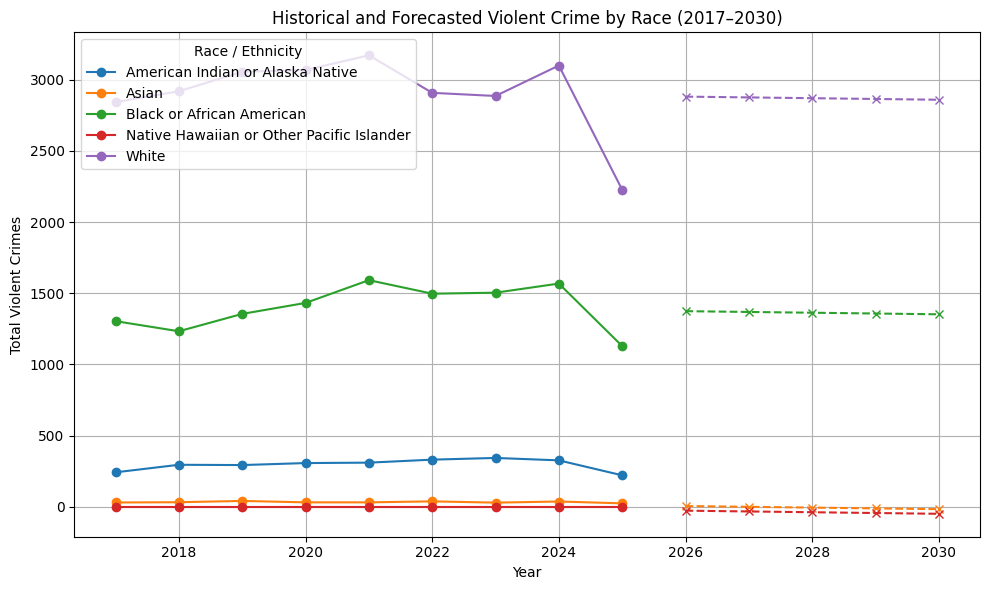

In [ ]:
# Get all unique race names
unique_races = race_crime_summary['Arrest Offense'].unique()

# Create a consistent color palette for all groups
palette = sns.color_palette("tab10", n_colors=len(unique_races))
color_map = dict(zip(unique_races, palette))

plt.figure(figsize=(10,6))

# Plot historical data
for race in unique_races:
    subset_hist = race_crime_summary[race_crime_summary['Arrest Offense'] == race]
    plt.plot(
        subset_hist['Year'],
        subset_hist['Violent Crime'],
        marker='o',
        color=color_map[race],
        label=race  # legend label only once
    )

# Plot forecast data with matching colors + dashed style
for race in unique_races:
    subset_fore = future_df[future_df['Race'] == race]
    plt.plot(
        subset_fore['Year'],
        subset_fore['Predicted Crime'],
        linestyle='--',
        marker='x',
        color=color_map[race]
    )

# Titles and labels
plt.title("Historical and Forecasted Violent Crime by Race (2017–2030)")
plt.xlabel("Year")
plt.ylabel("Total Violent Crimes")

# Single clean legend
plt.legend(title="Race / Ethnicity", loc='upper left')

plt.grid(True)
plt.tight_layout()
plt.show()


Research Question 2: Is there a difference in violent crime arrests between male and female over time?

In [ ]:
# creating a sex data frame
df_sex = df_cleaned[df_cleaned['Demographic_Type'] == 'Sex']

In [ ]:
# Grouping the data by year and sex
sex_year = (
    df_sex.groupby(['Year', 'Arrest Offense'])['Violent Crime']
    .sum()
    .reset_index()
)

In [ ]:
# Encoding the sex variable as male vs female
sex_year['Sex_Code'] = (sex_year['Arrest Offense'] == 'Male').astype(int)

In [ ]:
# Building linear regression model
X = sex_year[['Year', 'Sex_Code']]
y = sex_year['Violent Crime']

model = LinearRegression()
model.fit(X, y)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

Intercept: 28655.38333333339
Coefficients: [ -13.71666667 2771.33333333]


In [ ]:
# Statistical signifigance p-values
X2 = sm.add_constant(X)
model2 = sm.OLS(y, X2).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:          Violent Crime   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     230.3
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           5.52e-12
Time:                        04:59:36   Log-Likelihood:                -124.94
No. Observations:                  18   AIC:                             255.9
Df Residuals:                      15   BIC:                             258.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.866e+04   5.06e+04      0.567      0.5

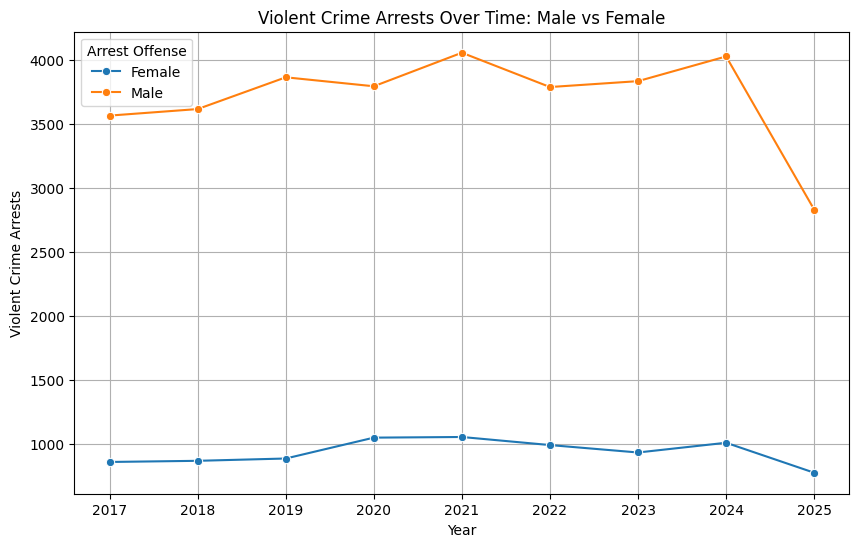

In [ ]:
# Visualizing the regression
plt.figure(figsize=(10,6))
sns.lineplot(data=sex_year, x='Year', y='Violent Crime', hue='Arrest Offense', marker='o')
plt.title("Violent Crime Arrests Over Time: Male vs Female")
plt.ylabel("Violent Crime Arrests")
plt.grid(True)
plt.show()

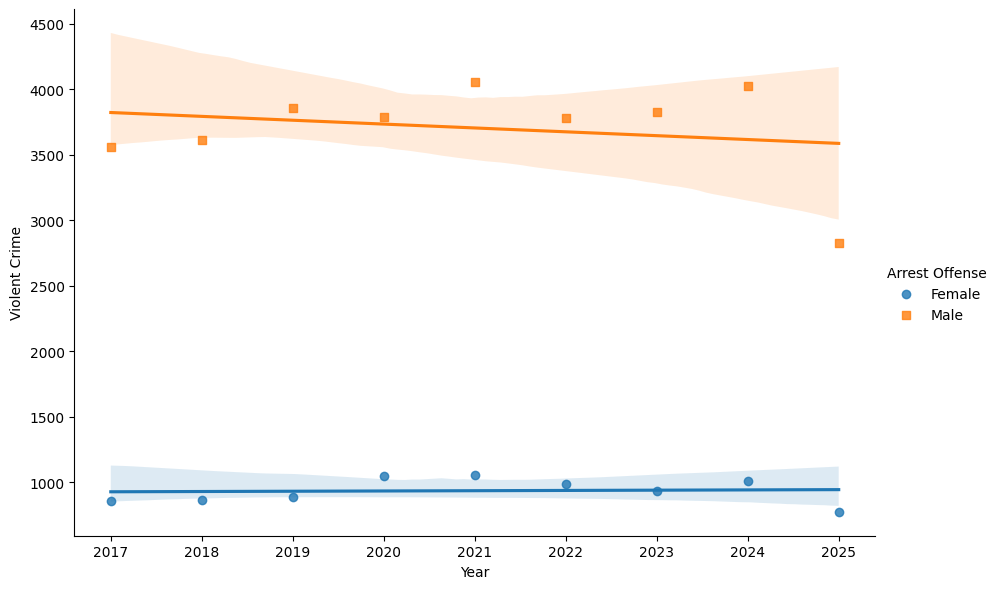

In [ ]:
# Regression fit
sex_year['Predicted'] = model2.predict(X2)

sns.lmplot(
    data=sex_year,
    x='Year',
    y='Violent Crime',
    hue='Arrest Offense',
    height=6,
    aspect=1.5,
    markers=['o','s'],
    ci=95
)

Research Question 3: Have violent crimes increased or decreased from 2017 to 2025?

Linear Regression R² Score: 0.028108658365989192


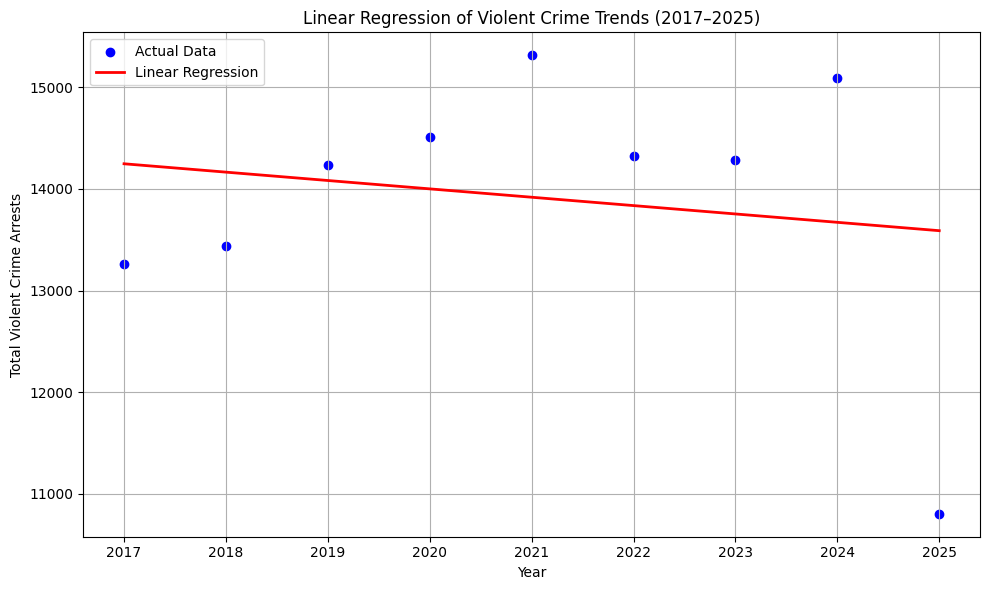

In [ ]:
year_totals = df_cleaned.groupby("Year")["Violent Crime"].sum().reset_index()

X = year_totals[["Year"]].values          # shape (n_samples, 1)
y = year_totals["Violent Crime"].values   # shape (n_samples,)

# Linear regression model
model = LinearRegression()
model.fit(X, y)

# Generate smooth prediction line across the year range
year_range = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
y_pred = model.predict(year_range)

# Calculate R² score on the original data
r2 = r2_score(y, model.predict(X))
print("Linear Regression R² Score:", r2)

# Plot the results
plt.figure(figsize=(10, 6))

# Actual data points
plt.scatter(X, y, color="blue", label="Actual Data")

# Linear regression line
plt.plot(year_range, y_pred, color="red", linewidth=2,
         label="Linear Regression")

plt.title("Linear Regression of Violent Crime Trends (2017–2025)")
plt.xlabel("Year")
plt.ylabel("Total Violent Crime Arrests")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Polynomial Regression R² Score: 0.7399527626582468


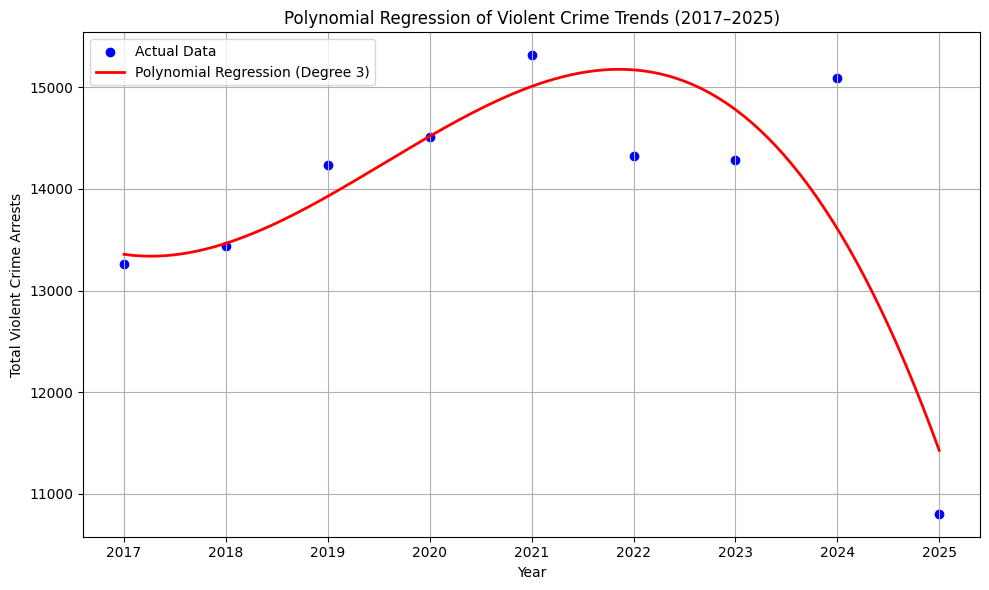

In [ ]:
# Polynomial transformation (degree 3)
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

# Fit polynomial regression model
model = LinearRegression()
model.fit(X_poly, y)

# Generate smooth prediction curve
year_range = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
year_range_poly = poly.transform(year_range)
y_pred = model.predict(year_range_poly)

# Calculate R² score
r2 = r2_score(y, model.predict(X_poly))
print("Polynomial Regression R² Score:", r2)

# Plot the results
plt.figure(figsize=(10,6))

# Actual data points
plt.scatter(X, y, color="blue", label="Actual Data")

# Polynomial regression curve
plt.plot(year_range, y_pred, color="red", linewidth=2, label="Polynomial Regression (Degree 3)")

plt.title("Polynomial Regression of Violent Crime Trends (2017–2025)")
plt.xlabel("Year")
plt.ylabel("Total Violent Crime Arrests")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipython-input-1937593213.py:4: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'Y' instead.
  ts = year_totals.set_index(pd.to_datetime(year_totals['Year'], format='%Y').dt.to_period('A'))["Violent Crime"]
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:          Violent Crime   No. Observations:                    9
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -70.549
Date:                Fri, 21 Nov 2025   AIC                            147.098
Time:                        04:59:40   BIC                            147.336
Sample:                    12-31-2017   HQIC                           145.491
                         - 12-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5048     11.081     -0.046      0.964     -22.224      21.214
ma.L1          0.4726     11.468      0.041      0.967     -22.003      22.949
sigma2      2.957e+06   1.98e+06      1.490      0.1

/tmp/ipython-input-1937593213.py:25: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'Y' instead.
  future_years = pd.period_range(start=str(last_year.year + 1), end=str(final_year), freq='A')


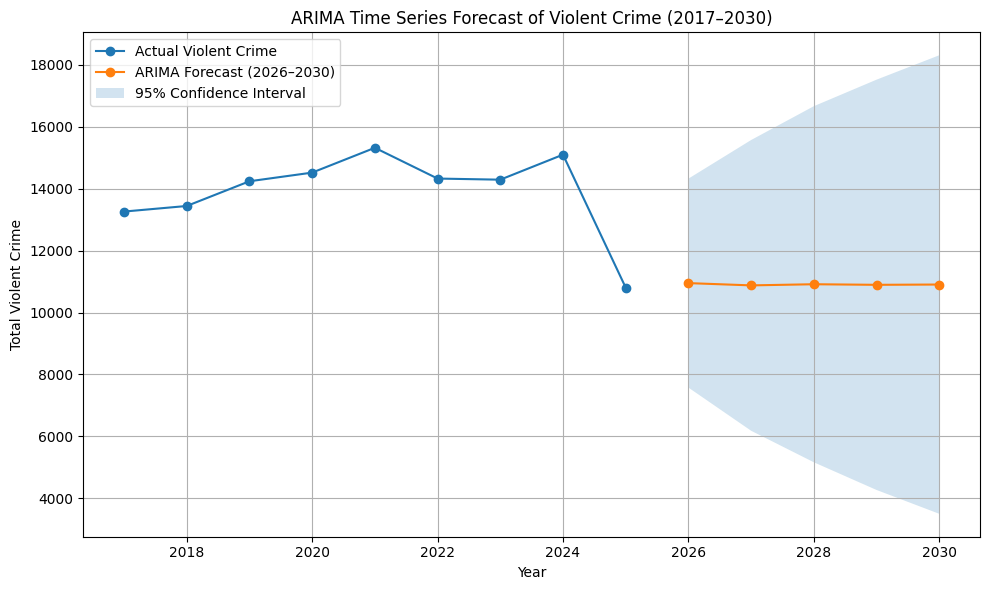

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Time series with Year as index, converted to PeriodIndex for statsmodels
ts = year_totals.set_index(pd.to_datetime(year_totals['Year'], format='%Y').dt.to_period('A'))["Violent Crime"]

# Fit ARIMA model
# Basic ARIMA(p,d,q) = (1,1,1)
model = ARIMA(ts, order=(1, 1, 1))
results = model.fit()

print(results.summary())

# Forecast up to year 2030
last_year = ts.index.max()          # should be 2025 (as Period object)
final_year = 2030
steps = final_year - last_year.year      # number of years to forecast (2026–2030 which is 5yrs)

forecast_res = results.get_forecast(steps=steps)

# Predicted means and confidence intervals
pred_mean = forecast_res.predicted_mean
pred_ci = forecast_res.conf_int()

# Give forecast a clean integer year index, using PeriodIndex for consistency
future_years = pd.period_range(start=str(last_year.year + 1), end=str(final_year), freq='A')
pred_mean.index = future_years
pred_ci.index = future_years

# Put forecast into a DataFrame
forecast_df = pd.DataFrame({
    "Year": [p.year for p in future_years],
    "Forecasted Violent Crime": pred_mean.values,
    "Lower CI": pred_ci.iloc[:, 0].values,
    "Upper CI": pred_ci.iloc[:, 1].values
})

print("\nARIMA Forecast 2026–2030:")
print(forecast_df)

# Plot historical data + forecast
plt.figure(figsize=(10, 6))

# Historical series
plt.plot([p.year for p in ts.index], ts.values, marker="o", label="Actual Violent Crime")

# Forecasted mean
plt.plot([p.year for p in future_years], pred_mean.values, marker="o",
         label="ARIMA Forecast (2026–2030)")

# Confidence interval shading
plt.fill_between(
    [p.year for p in future_years],
    pred_ci.iloc[:, 0].values,
    pred_ci.iloc[:, 1].values,
    alpha=0.2,
    label="95% Confidence Interval"
)

plt.title("ARIMA Time Series Forecast of Violent Crime (2017–2030)")
plt.xlabel("Year")
plt.ylabel("Total Violent Crime")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()